In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path

import sys 
sys.path.insert(0, "../../../src")

import numpy as np
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import SingleCellAndCodexDataset 
from model import FlowMatchingModelWrapper
from torch.utils.data import random_split
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

plt.rcParams['figure.figsize'] = (3, 3) 

Initialize configuration dict

In [71]:
with initialize(config_path="../../../configs/"):
    # Step 2: Compose the configuration
    config_dict = compose(config_name="train",
                          overrides=["datamodule=tonsilitis_cite"])  

/tmp/ipykernel_2610746/3711289577.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../../../configs/"):


Model

In [72]:
dataset = SingleCellAndCodexDataset(config_dict.datamodule.rna_adata_path, 
                                        config_dict.datamodule.codex_adata_path, 
                                        config_dict.datamodule.label_columns, 
                                        config_dict.datamodule.obsm_key_rna, 
                                        config_dict.datamodule.obsm_key_codex) 

In [73]:
model = FlowMatchingModelWrapper(input_dim=dataset.input_dim,
                                    hidden_dim=config_dict.model.hidden_dim,
                                    num_hidden_layers=config_dict.model.num_hidden_layers,
                                    time_embedding_dim=config_dict.model.time_embedding_dim,
                                    source_condition_dim=dataset.source_dim, 
                                    use_batchnorm=config_dict.model.use_batchnorm,
                                    sigma=config_dict.model.sigma, 
                                    flavor=config_dict.model.flavor, 
                                    learning_rate=config_dict.model.learning_rate, 
                                    weight_decay=config_dict.model.weight_decay, 
                                    distance=config_dict.model.distance)

Checkpoints

## Collect trained model

In [74]:
ckpts = torch.load("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/experiements/cool-terrain-11/checkpoints/last.ckpt")

In [75]:
model.load_state_dict(ckpts["state_dict"])

<All keys matched successfully>

### Read CODEX data

In [76]:
adata_codex = sc.read_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/codex/citeseq/250830_generated_cells_processed.h5ad")

### Read scRNA-seq data

In [77]:
adata_scrnaseq = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/citeseq/CITEseq_protein_processed.h5ad")

## Perform pushforward 

In [78]:
# Step 1: Wrap the CODEX data in a PyTorch Dataset
class CodexDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data.X).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# Step 2: Define cluster assignment via nearest neighbors
def cluster_assignment(X_hat, X_true, true_annot, n_neighs=1):
    nn_model = KNeighborsClassifier(n_neighbors=n_neighs, algorithm='auto')
    nn_model.fit(X_true, true_annot)
    indices = nn_model.predict(X_hat)
    return indices

In [79]:
# Step 3: Prepare data and loader
codex_dataset = CodexDataset(adata_codex)
codex_loader = DataLoader(codex_dataset, batch_size=1000, shuffle=False)

real_annot = np.array(adata_scrnaseq.obs.annotation_figure_1)
X_true = adata_scrnaseq.obsm["X_harmony_RNA"]  # assumed (n_cells_rna, n_features)

# Step 4: Run inference and assignment in batches
assigned_annots = []
X_harmony_hat = []

for batch in codex_loader:
    X_codex = batch  # already a torch tensor
    X_rna_hat = model.pushforward(
        x0=X_codex,
        n_timesteps=2,
        solver="dopri5"
    ).detach().cpu().numpy()

    batch_annots = cluster_assignment(X_rna_hat, X_true, real_annot, n_neighs=5)
    
    assigned_annots.append(batch_annots)
    X_harmony_hat.append(X_rna_hat)
    
# Step 5: Concatenate all annotations
assigned_annots = np.concatenate(assigned_annots)
X_harmony_hat = np.concatenate(X_harmony_hat, axis=0)

adata_codex.obs["cell_type"] = assigned_annots
adata_codex.obsm["predicted_harmony"] = X_harmony_hat

Examine results

In [80]:
sc.tl.pca(adata_codex)
sc.pp.neighbors(adata_codex)
sc.tl.umap(adata_codex)

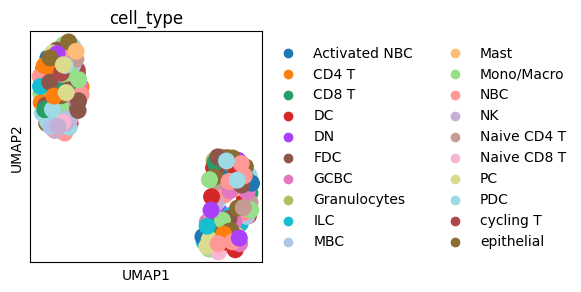

In [81]:
sc.pl.umap(adata_codex,color="cell_type")

## Add decoded genes 

In [82]:
sys.path.insert(0, "/home/icb/alessandro.palma/environment/scportrait_ot/src")
from dataloader import EmbeddingDecoderDataset
from decoding_modules import DecoderFromHarmony
from pathlib import Path

#### HVGs

In [83]:
dataset = EmbeddingDecoderDataset(adata_path="/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed.h5ad", 
                                     count_label="X_normalized_log", 
                                     embedding_label="X_harmony_RNA",
                                     batch_label="donor_id")

In [84]:
decoder_model = DecoderFromHarmony(input_dim=dataset.input_dim, 
                                   output_dim=dataset.output_dim,
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3, 
                                   likelihood="gaussian"
                                  )

decoder_model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/experiements/decoder_cite_log/generous-sunset-3/checkpoints/last.ckpt")["state_dict"])

<All keys matched successfully>

In [85]:
with torch.no_grad():
    X_hat = decoder_model.decoder(torch.from_numpy(adata_codex.obsm["predicted_harmony"]))

In [86]:
adata_codex.obsm["X_gexp_log"] = X_hat.detach().cpu().numpy()
adata_codex

AnnData object with n_obs × n_vars = 200 × 31
    obs: 'label', 'cell_type'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'predicted_harmony', 'X_pca', 'X_umap', 'X_gexp_log'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Whole genome 

In [ ]:
dataset = EmbeddingDecoderDataset(adata_path="/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed_full_genome.h5ad", 
                                     count_label="X_normalized_log", 
                                     embedding_label="X_harmony_RNA",
                                     batch_label="donor_id")

In [ ]:
decoder_model = DecoderFromHarmony(input_dim=dataset.input_dim, 
                                   output_dim=dataset.output_dim,
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3, 
                                   likelihood="gaussian"
                                  )

decoder_model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/experiements/decoder_cite_log_whole_genome/pretty-music-1/checkpoints/last.ckpt")["state_dict"])

In [ ]:
with torch.no_grad():
    X_hat = decoder_model.decoder(torch.from_numpy(adata_codex.obsm["predicted_harmony"]))

In [ ]:
adata_codex.obsm["X_gexp_log_whole_genome"] = X_hat.detach().cpu().numpy()
adata_codex

## Add var names 

In [ ]:
adata_cite = sc.read_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna.h5ad")

In [ ]:
list(adata_cite.var.index)

In [ ]:
adata_codex.uns["var_names_hvg"] = list(adata_cite.var.index)

In [ ]:
adata_codex.uns["var_names_whole_genome"] = list(adata_cite.raw.var.index)

In [ ]:
len(adata_codex.uns["var_names_hvg"])

In [ ]:
len(adata_codex.uns["var_names_whole_genome"])

In [ ]:
adata_codex.write_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/predicted_codex/predicted_ct_tonsilitis_decoded_generated.h5ad")